In [12]:
import torch
import torch.nn as nn
import librosa
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence

# 1. Device (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Redefine your LSTMClassifier (exactly as in training)
class CNNLSTMClassifier(nn.Module):
    def __init__(self,
                 input_features: int,
                 hidden_size: int,
                 num_layers: int,
                 num_classes: int,
                 bidirectional: bool = True,
                 dropout: float = 0.5):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=(1, 1)),  # Conv2d: [B, 1, T, F] -> [B, 16, T, F]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # -> [B, 16, T//2, F//2]
            
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=(1, 1)),  # -> [B, 32, T//2, F//2]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # -> [B, 32, T//4, F//4]
        )

        self.lstm_input_size = 32 * (input_features // 4)  # Features after pooling
        self.lstm = nn.LSTM(input_size=self.lstm_input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), num_classes)

    def forward(self, x, lengths):
        # x shape: [B, T, F]
        x = x.unsqueeze(1)  # [B, 1, T, F]
        x = self.conv(x)    # -> [B, 32, T//4, F//4]
        B, C, T_new, F_new = x.size()
        x = x.permute(0, 2, 1, 3).contiguous()  # [B, T_new, C, F_new]
        x = x.view(B, T_new, -1)  # [B, T_new, C * F_new] = ready for LSTM

        # Adjust lengths to account for two 2x pooling layers in time dimension
        lengths = lengths // 4
        # Make sure lengths are at least 1 and no greater than T_new
        lengths = torch.clamp(lengths, min=1, max=T_new)
        
        # Pack sequence
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_out, (h_n, c_n) = self.lstm(packed)

        if self.lstm.bidirectional:
            n_layers = self.lstm.num_layers
            H = self.lstm.hidden_size
            h_n = h_n.view(n_layers, 2, -1, H)
            h_fwd = h_n[-1, 0]
            h_bwd = h_n[-1, 1]
            h = torch.cat([h_fwd, h_bwd], dim=-1)
        else:
            h = h_n[-1]

        out = self.dropout(h)
        logits = self.fc(out)
        return logits

emotion2idx = {'angry': 0,
 'calm': 1,
 'disgust': 2,
 'fearful': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprised': 7}

# 3. Instantiate & load your trained weights
input_size  = 13 + 12   # MFCC + Chroma dims
hidden_size = 128       # same as training
num_layers  = 2
num_classes = 8         # RAVDESS has 8 emotion labels

input_size   = 13 + 12             # MFCCs + Chroma
hidden_size  = 128
num_layers   = 2
num_classes  = len(emotion2idx)
lr           = 1e-3
batch_size   = 32
num_epochs   = 100
model = CNNLSTMClassifier(input_size, hidden_size, num_layers, num_classes)
model.load_state_dict(torch.load('best_lstm_emotion_run_cnn_preoverfitting.pth', map_location=device))
model.to(device)
model.eval()


# 4. Emotion label mapping
# (Use exactly the same mapping you trained with!)
emotion2idx = {'neutral':0,'calm':1,'happy':2,'sad':3,'angry':4,'fearful':5,'disgust':6,'surprised':7}
idx2emotion = {v:k for k,v in emotion2idx.items()}
emotion_names = [idx2emotion[i] for i in range(num_classes)]

In [13]:
import sounddevice as sd
from scipy.io.wavfile import write

# duration = 3  # 5 seconds of recording
# fs = 44100  # Sample rate

# print("Recording...")
# sd.default.device = 7
# recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
# sd.wait()
# write("recorded.wav", fs, recording)
# print("Saved to recorded.wav")
audio_path = '../data/Actor_18/03-01-06-02-01-01-18.wav'  # ← replace!

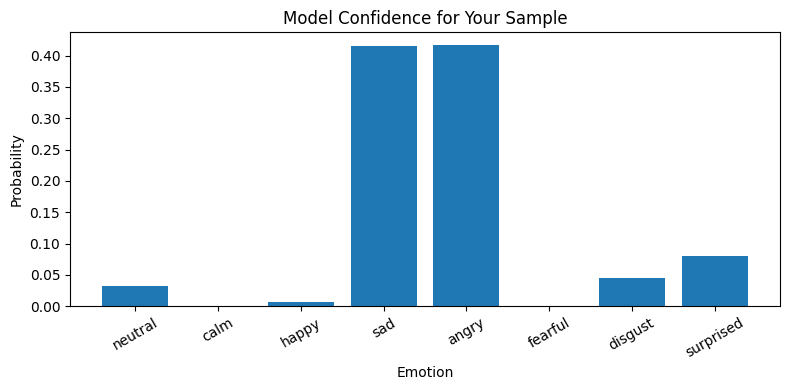

In [15]:
# 5. Load & featurize your sample
y, sr = librosa.load(audio_path, sr=None)
mfcc   = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12)
feats  = np.vstack([mfcc, chroma]).T            # shape (T, D)
feats  = torch.from_numpy(feats).float().unsqueeze(0)  # (1, T, D)
length = torch.tensor([feats.size(1)])

# 6. Predict & get probabilities
with torch.no_grad():
    logits = model(feats.to(device), length.to(device))
    probs  = torch.softmax(logits, dim=1).cpu().numpy().flatten()

# 7. Plot confidence across emotions
plt.figure(figsize=(8,4))
plt.bar(emotion_names, probs)
plt.xlabel('Emotion')
plt.ylabel('Probability')
plt.title('Model Confidence for Your Sample')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('emotion_confidence.png')
plt.show()